# 1. Import the necessary packages to use in this project

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# 2. Lets load our data from the directory
Print to check if it is the correct directory
Windows uses \\ in their dir while MacOS or Linux uses //

We will load 3000 images from our dataset, containing 1000 images from each class (cat dog and car respectively)

# 3. Create an empty array called 'categories'& Put data into DataFrame (2D array table)
Category names are cat,dog and car. 
*Arrays must be same length (3 letters)
Now we assign an integer according to the categories assigned

In [3]:
filenames = os.listdir('C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\data')

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'car': 
        categories.append(0)  #The categories are set as labels
    elif category == 'cat': 
        categories.append(1)
    elif category == 'dog':
        categories.append(2)
        
df = pd.DataFrame({
    'filename': filenames,  
    'category': categories,    
})

df


,filename,category
0,car.0.jpg,0
1,car.1.jpg,0
2,car.10.jpg,0
3,car.100.jpg,0
4,car.101.jpg,0
...,...,...
2995,dog.995.jpg,2
2996,dog.996.jpg,2
2997,dog.997.jpg,2
2998,dog.998.jpg,2


1    1000
2    1000
0    1000
Name: category, dtype: int64

 Total images:  3000


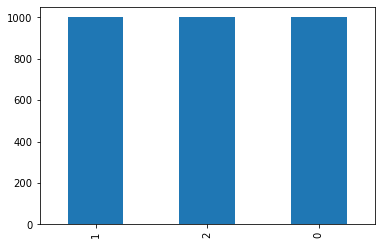

In [4]:
# Lets see total images and in each category

df['category'].value_counts().plot.bar()
print(df['category'].value_counts())

print("\n Total images: ", df.shape[0])

Lets see a sample of our image

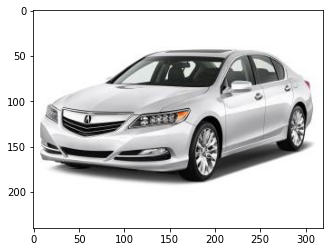

In [5]:
sample = random.choice(filenames)
image = load_img('C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\data\\'+sample)
plt.imshow(image)

# 4. For our image classifier, we will create a Convolutional Neural Network which is best suited for learning images.
You can try training without BatchNorm and Dropout layers, to see what happens.
BatchNorm and Dropout is used to reduce overfitting (Val loss higher than train loss in graph below)

The number beside Conv2D are the amount of features to extract
Flatten layer is used to combine all extracted features 
Final Dense layer is 3 because we have 3 classes (car,cat,dog) to classify. 

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(96, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax')) # 3 because we have car, dog and cat classes

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)             0         
__________

# 5. Get callback for early stopping
Use ReduceLR to reduce learning rate when metric not improving

In [45]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
callbacks = [earlystop, learning_rate_reduction]

Use ImageGenerator to convert data to 1 hot encoding

In [46]:
df["category"] = df["category"].replace({ 0: 'car', 1: 'cat', 2: 'dog' })

In [47]:
df["category"].head()

0    car
1    car
2    car
3    car
4    car
Name: category, dtype: object

# 6. Lets split our files into 80% train and 20% validation. This is common practice in CNN.
Set state=0 to prevent random splitting

dog    824
cat    813
car    763
Name: category, dtype: int64

 Total train images:  2400


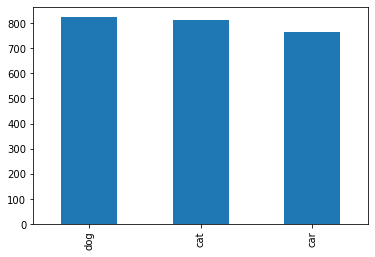

In [48]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=0) 

# Lets see total 'TRAIN' files and in each category
train_df = train_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
print(train_df['category'].value_counts())
print("\n Total train images: ", train_df.shape[0])

car    237
cat    187
dog    176
Name: category, dtype: int64

 Total validate images:  600


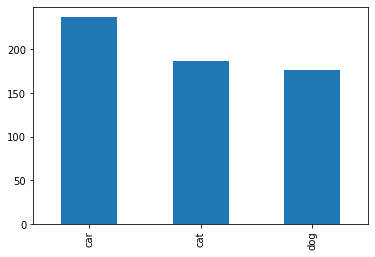

In [49]:
# Lets see total 'VALIDATE' files and in each category

validate_df = validate_df.reset_index(drop=True)
validate_df['category'].value_counts().plot.bar()

print(validate_df['category'].value_counts())
print("\n Total validate images: ", validate_df.shape[0])

In [54]:
# Get total train and validate, and batch size to fit model

total_train = train_df.shape[0]
print("Total train images:", total_train)

total_validate = validate_df.shape[0] 
print("Total validate images:", total_validate)

Total train images: 2400
Total validate images: 600


# 7. Using Data augmentation will help us to artificially increase our dataset by 3 times or more.
You can refer to the link here to understand more about the features of data augmentation - 
https://mc.ai/image-data-augmentation-image-processing-in-tensorflow-part-2/

In [94]:
train_datagen = ImageDataGenerator(
                                    rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\data\\", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\data\\", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


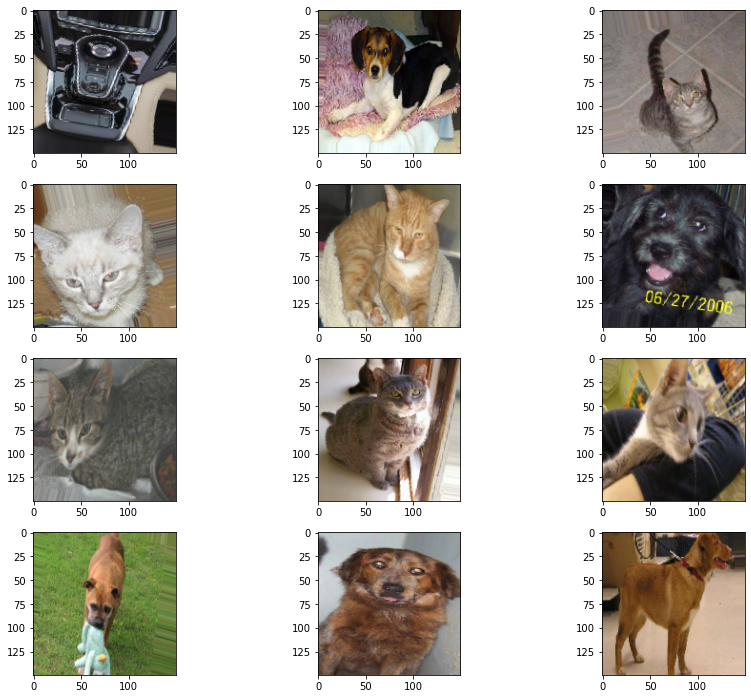

In [95]:
# Lets take a look at how augmented images from train generator look like

plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# 8. Train the model

In [96]:
epochs=50
batch_size=50

history = model2.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate/batch_size,
    steps_per_epoch=total_train/batch_size,
    callbacks=callbacks
)

Epoch 1/50


INFO:plaidml:Analyzing Ops: 78 of 248 operations complete


48/48 [==============================] - 101s 2s/step - loss: 0.4772 - acc: 0.7799 - val_loss: 0.5004 - val_acc: 0.7839
Epoch 2/50
48/48 [==============================] - 97s 2s/step - loss: 0.4923 - acc: 0.7747 - val_loss: 0.4144 - val_acc: 0.8138
Epoch 3/50
48/48 [==============================] - 72s 2s/step - loss: 0.4706 - acc: 0.7695 - val_loss: 0.5013 - val_acc: 0.7604
Epoch 4/50
48/48 [==============================] - 78s 2s/step - loss: 0.4689 - acc: 0.7812 - val_loss: 0.4755 - val_acc: 0.7952
Epoch 5/50
48/48 [==============================] - 70s 1s/step - loss: 0.4856 - acc: 0.7734 - val_loss: 0.4554 - val_acc: 0.7872
Epoch 6/50
48/48 [==============================] - 72s 1s/step - loss: 0.4969 - acc: 0.7513 - val_loss: 0.4592 - val_acc: 0.7969
Epoch 7/50
48/48 [==============================] - 69s 1s/step - loss: 0.4868 - acc: 0.7650 - val_loss: 0.5080 - val_acc: 0.7872

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 8/50
48/48 [=================

# 9. Plot graph for train/val loss & train/val acc
Usually, low train & val loss + high acc * val acc = well predicted model.
Overfitting occurs if validation loss is higher than training loss.
Spikes are caused by a few reasons - insufficient data/learning rate value

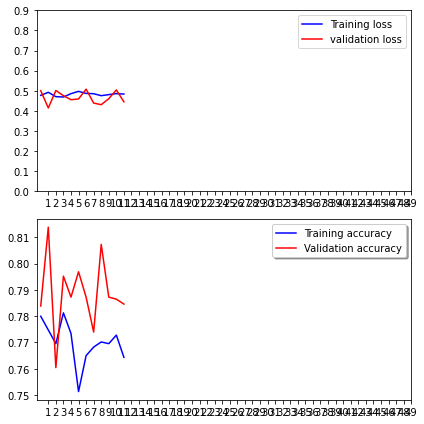

In [97]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# 10. Save the trained model to re-use without having to re-train

# 11. Load saved model

You can set any filename you like, I set mine as 'cardogcat1' 
*Comment away the load command before saving, vice-versa for loading model.
*Comment away the model.fit code and graph plot code when loading model as you wont need them

In [109]:
#model2.save('catdogcar2.hdf5')

#"""
from keras import models    
model = models.load_model('catdogcar2.hdf5', compile = False)
#"""

# 12. Prepare test data
You can specify a different folder to predict on different kinds of image.
I have 150 images in my test data, which contain 50 images for each class

In [110]:
test_filenames = os.listdir("C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\test")
test_df = pd.DataFrame({
    'filename': test_filenames
})

Check total images in test folder

In [111]:
total_test = test_df.shape[0]  
print("Total amount of test images are:", total_test)

Total amount of test images are: 150


# 13. Create test generator
Batch_size is 15 to run through batches for large dataset  

In [112]:
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=batch_size,
    shuffle=False 
)

Found 150 validated image filenames.


# 14. Prediction of test data
np.ceil to round off array value to whole number
Use reset outputs in orderly manner

In [113]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size))

# Get total predicteed images       

print("Number of predicted images:", len(predict), "\n")

# Get predictions in array
# These are labels 0, 1, 2 (category)
# Use [?:?] to specify range of index in list/array

print("    0:car          1:cat       2:dog \n\n", predict, "\n")   

Number of predicted images: 150 

    0:car          1:cat       2:dog 

 [[5.11558633e-03 3.35575968e-01 6.59308434e-01]
 [1.03974526e-05 7.25152910e-01 2.74836689e-01]
 [2.91420013e-01 3.41067612e-01 3.67512435e-01]
 [9.99942780e-01 2.35456573e-05 3.36684861e-05]
 [9.75099921e-01 6.37103163e-04 2.42630336e-02]
 [9.99709308e-01 2.39777029e-04 5.09335478e-05]
 [5.91919525e-03 5.94480872e-01 3.99599910e-01]
 [9.63890329e-02 3.74267846e-01 5.29343188e-01]
 [4.68899123e-02 3.42911035e-01 6.10199094e-01]
 [9.98336136e-01 6.87253341e-05 1.59523089e-03]
 [3.12267333e-01 1.87298074e-01 5.00434637e-01]
 [1.01773403e-05 5.07665753e-01 4.92324054e-01]
 [1.61896387e-04 6.07247591e-01 3.92590553e-01]
 [2.41690516e-01 1.29392430e-01 6.28917098e-01]
 [2.11540386e-02 4.09864247e-01 5.68981707e-01]
 [3.21886240e-04 7.57677913e-01 2.42000282e-01]
 [5.30420220e-05 4.84878361e-01 5.15068650e-01]
 [7.00931251e-02 4.19887722e-01 5.10019183e-01]
 [1.66226167e-03 6.39474273e-01 3.58863533e-01]
 [1.02832436e-

# 15. Use np.argmax to get max value from array as predicted answer

In [114]:
test_df['category'] = np.argmax(predict, axis=-1) 

# Lets see the some predicted values for each category of images
# Use [?:?] to specify range 

print(test_df['category'][0:3]) 

0    2
1    1
2    2
Name: category, dtype: int64


# 16. Use train class indices for mapping

In [115]:
print(train_generator.class_indices) 
print(validation_generator.class_indices, "\n")

# Map labels 
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
print(label_map, "\n")

# See the output of mapped labels
print(test_df['category'][0:4], "\n")

# Lets replace letters with words to see better
print(test_df['category'][0:3])

{'car': 0, 'cat': 1, 'dog': 2}
{'car': 0, 'cat': 1, 'dog': 2} 

{0: 'car', 1: 'cat', 2: 'dog'} 

0    dog
1    cat
2    dog
3    car
Name: category, dtype: object 

0    dog
1    cat
2    dog
Name: category, dtype: object


# 17. View the amount of predicted image in category assigned 
It seems that the model was able to predict fairly, however, the predictions can be improved with fine tuning by testing on the train dataset. 

dog    68
car    51
cat    31
Name: category, dtype: int64

Total predicted images: 150


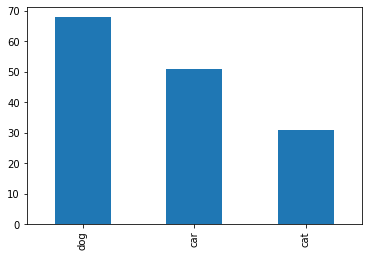

In [116]:
test_df['category'].value_counts()
print(test_df['category'].value_counts())

# View the above in a bar graph
test_df['category'].value_counts().plot.bar()

# Lets print the total predicted images 
print("\nTotal predicted images:", test_df.shape[0])

# 18. View predicted result with images
Calculate amt of subplot ( x * y = total value of plots displayed)
Some of our images are wrongly predicted, you can improve the prediction accuracy by changing the neural network model.
Perhaps you can add more convolutional & max pooling layers. Or check google for more tips on improving image predictions!

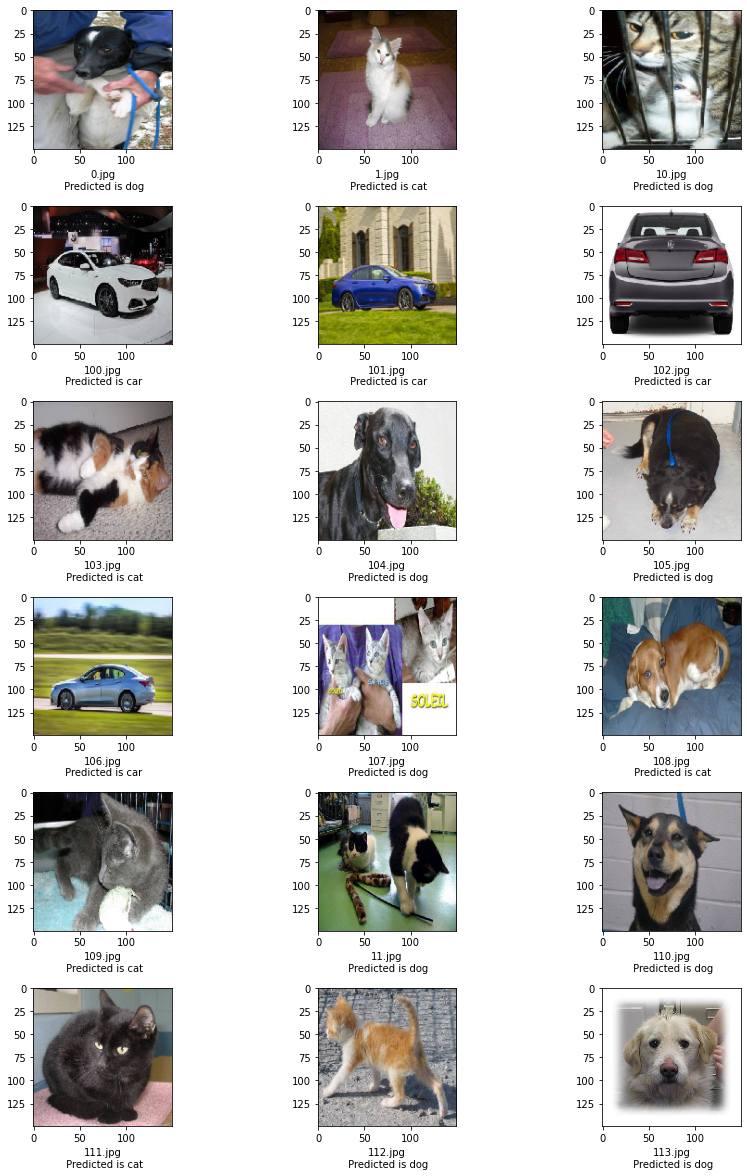

In [117]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\kansh\\Desktop\\Entire FYP Folder\\FYP Notebooks (Workstation)\\cats_dogs_cars\\test\\"+filename, target_size=(150,150)) #rescale(1./255)
    plt.subplot(9, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + "\n Predicted is " + "{}".format(category))
plt.tight_layout()
plt.show()

# 19. Lastly, save predictions into CSV file

In [118]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('Catdogcar1.csv', index=False)

submission_df.head(300)

,id,label
0,0,dog
1,1,cat
2,10,dog
3,100,car
4,101,car
...,...,...
145,95,dog
146,96,car
147,97,car
148,98,car
